# Notebook with CVAE model and conditionning over day of the week, month and temperature

## Loading Libraries 

In [ ]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

In [ ]:
#paths in git

#root git folder 
#path_main_folder = '/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_'
path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [ ]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

In [4]:
#directories to store trained model and the related projector

log_dir_projector=path_main_folder+"/notebooks/logs/Expe3/CVAE_W_M_T/projector"
log_dir_model=path_main_folder+"/notebooks/logs/Expe3/CVAE_W_M_T//model"
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)

# Table of contents:
- Load Data
- Make Training Set
- Define and Train Model
- Build Projector
- Compute Feature Scores in latent space
- Study reconstruction Error
- Study Holidays prediction
- Detect atypical events
- Conclusion

# Load dataset 

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

In [6]:
#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

In [7]:
#Visualize data frame head
x_conso.head(5)

,ds,consumption_France,temperature_France,is_holiday_day
0,2012-12-28 00:00:00,59679.0,8.817600,0.0
1,2012-12-28 00:30:00,58103.0,8.690875,0.0
2,2012-12-28 01:00:00,55354.0,8.564150,0.0
3,2012-12-28 01:30:00,55196.0,8.440525,0.0
4,2012-12-28 02:00:00,54324.0,8.316900,0.0


# Make training set of daily electrical consumption profiles and conditions 
In this experiment, we use some conditions from expert knowledge we previosuly recovered (temperature, month, days of the week) to learn a new residual latent space.  

In [8]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

In [9]:
dict_xconso = {'train': x_conso}

In [10]:
# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


Give the features on which to condition

In [11]:
type_x = ['conso']
type_cond = ['day','month','temperature']
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond)

/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:212: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:215: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



(1830, 67)


/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:322: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:328: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [12]:

nPoints=dataset['train']['x'][1].shape[0]

#get conditions in array
days_emb =dataset['train']['x'][1][:,0:7]
month_emb =dataset['train']['x'][1][:,7:19]
temp_emb=dataset['train']['x'][1][:,19:]
to_emb=dataset['train']['x'][1]

x = dataset['train']['x'][0]

dataset['train']['x'] = [x,days_emb,month_emb,temp_emb]

In [13]:
np.shape(temp_emb)

(1830, 48)

In [14]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

# Build and train model CVAE

In [15]:
#on sauvegarde le dataset
path_out = log_dir_model

In [16]:
# Parameters for autoencoder
e_dims=[48,35,24,12]#encoder dim
d_dims=[48,35,24,12]#decoder dim. Dense Blocks in skip connections can make the dimensions bigger when layers are concatenated with the previous one
to_emb_dim=[7,12,48] #input dimensions for conditions
cond_pre_dim = 0
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 4
lambda_val = 0.4 #hyper-parameter which value was selected after cross-validation

In [17]:
name_model = 'cvae_conso-W_M_T_30min-journalier'
#name_model = 'cvae_classification'

In [18]:
#if needs to relaod model classes after modification wothout restarting the kernel

import CVAE.cvae_model
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.callbacks)

%load_ext autoreload
%autoreload

In [19]:
Lambda = K.variable(lambda_val, dtype='float32')
model = CVAE.cvae_model.CVAE_emb(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_pre_dim=cond_pre_dim,
                  z_dim=z_dim, 
                  beta=Lambda,
                  name=name_model, 
                  output=path_out,
                 to_emb_dim=to_emb_dim,
                 emb_dims=[[5,3],[6,3],[12,4]], emb_to_z_dim=[5,5],is_L2_Loss=False,has_BN=2)#these dimensions define the dimension layer of the conitional network

Instructions for updating:
Colocations handled automatically by placer.
5
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 7)            0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
emb_input_2 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
____

### Trainning model 

In [20]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)


We start a pre-training phase with a constant and high lambda to properly learn the conditional embedding



--- START TRAINING ---

Instructions for updating:
Use tf.cast instead.
emb_input_0
emb_input_1
emb_input_2
[1475.1929 3649.875  1722.8761 1582.1064]
4.33440847916667
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.847976  0.347736  0.540758        0.123636     0.851284
random model    0.487818  0.165654  0.080890        0.025455    -0.431882
0 Epochs ...  - loss: 27.4357 - decoder_loss: 25.9452 - decoder_for_kl_loss: 3.7262 - val_loss: 13.8838 - val_decoder_loss: 11.5968 - val_decoder_for_kl_loss: 5.7173 val_loss 13.883778483489824 ... lambda Loss 0.4000000059604645
emb_input_0
emb_input_1
emb_input_2
[1212.3762   1354.6976     86.733315   82.895134]
9.004563140625002
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.955310  0.454144  0.228153        0.229091     0.389828
random model    0.489197  0.141415  0.093394        0.014545    -0.444259
100 Epochs ...  - loss: 4.3149 - decoder_loss: 2.7597 

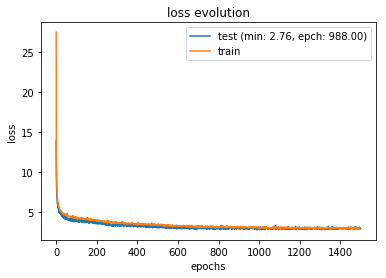

In [21]:
import warnings
warnings.filterwarnings('ignore')

lambda_decreaseRate=0.0
lambda_min=0.01 #p

#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=False
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model.main_train(dataset, training_epochs=1500, batch_size=32, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model.main_train(dataset, training_epochs=1500, batch_size=32, verbose=0,callbacks=[tensorboard],validation_split=0.1)


We now continue with a learning phase for better reconstruction and refine the similarities between instances. It can be seen as a diffusion phase. We smoothly decese the lambda after each epoch.



--- START TRAINING ---

emb_input_0
emb_input_1
emb_input_2
[ 600.0577   1153.4888     13.503026   22.041283]
10.529311708333331
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.617256  0.190134  0.157817        0.770909     0.118032
random model    0.484567  0.160258  0.094730        0.018182    -0.418034
0 Epochs ...  - loss: 2.9228 - decoder_loss: 1.9082 - decoder_for_kl_loss: 2.5363 - val_loss: 2.9787 - val_decoder_loss: 2.0684 - val_decoder_for_kl_loss: 2.2759 val_loss 2.9787429225900786 ... lambda Loss 0.4000000059604645
emb_input_0
emb_input_1
emb_input_2
[ 642.6066   1272.4303     20.489347   16.626772]
10.480601484375002
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.563449  0.190120  0.182838        0.810909     0.185167
random model    0.515808  0.154696  0.089071        0.032727    -0.435427
100 Epochs ...  - loss: 2.7782 - decoder_loss: 1.8072 - decoder_for_kl_loss: 2.6829 - val_loss:

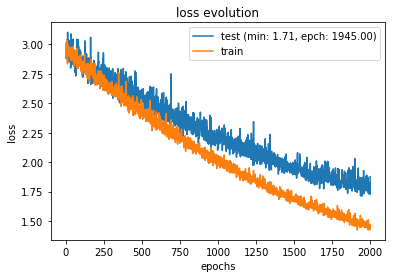

In [22]:
lambda_decreaseRate=0.001 #parameter by default

if runTraining:
    weightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min)
    if runBatchCallback:
        model.main_train(dataset, training_epochs=2000, batch_size=32, verbose=0,callbacks=[tensorboard,out_batch,weightLoss],validation_split=0.1)
    else:
        model.main_train(dataset, training_epochs=2000, batch_size=32, verbose=0,callbacks=[tensorboard,weightLoss],validation_split=0.1)


DimsImportance=[1264   1181     11   38] Only 2 dimensions are significant here (each term is the sum of absolute values in each direction for the all the datapoints.
There is no significant overfitting when comparing training error to validation error. This will be confimed later on specific examples.

In [23]:
if runTraining:
    with open(os.path.join(log_dir_model,name_model,"config.txt"),'w') as file: 
        file.write(str(cond_pre_dim) + '\n')
        #file.write(str(emb_dims) + '\n')
        file.write(str(e_dims) + '\n') 
        file.write(str(d_dims) + '\n') 
        file.write(str(z_dim) + '\n')
        file.write(str(Lambda) + '\n')

In [24]:
#sauvegarde du dataset associé
if runTraining:
    name_dataset = 'dataset.pickle'

    with open( os.path.join(log_dir_model,name_model, name_dataset), "wb" ) as file:
        pickle.dump( dataset, file )

## Loading model 

In [55]:
model.load_model(os.path.join(path_out, name_model, 'models'))

In [56]:
emb_inputs=[days_emb,month_emb,temp_emb]
emb_ouputs = model.embedding_enc.predict(emb_inputs)

#cond_pre=day_emb
#cond = np.concatenate((cond_pre, emb_ouputs), axis=1)
cond  = emb_ouputs
x_input = dataset['train']['x'][0]

input_encoder = [x_input,cond]

In [57]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])[0]

# Analysis of the latent space with the construction of a tensorboard projector

In [58]:
includeConsumptionProfileImages=True #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
if includeConsumptionProfileImages:
    nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
    x_encoded_reduced=x_encoded[0:nPoints,]
    images=createLoadProfileImages(x,x_hat,nPoints)
else:
    nPoints=1830

In [59]:
if includeConsumptionProfileImages:
    sprites=images_to_sprite(images)
    cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)

In [60]:

writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
if includeConsumptionProfileImages:
    buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
else:
    buildProjector(x_encoded,images=None, log_dir=log_dir_projector)

In [61]:
log_dir_projector

'/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/notebooks/logs/Expe3/CVAE_W_M_T/projector'

It is possible to explore the resulting latent projection with tensorboard. You should easily visualize holidays and similar non-working days: like the Christmas Week or days happening before or after holidays

# Predict Features in latent space

In [62]:
df_noCond_VAE=predictFeaturesInLatentSPace(x_conso,calendar_info,x_encoded)

12.219337010416663
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.590781  0.189577  0.143480        0.745455    -0.200984
random model    0.495069  0.142156  0.090278        0.021818    -0.387472


We can notice that for the conditions passed (W-M-T), their recovery score in the residual latent space is closed to random. On the other hand, the recovery score of holidays is now high. So the residual latent space is now much more dependant over this feature: holidays are now well-represented in this representation.  

# reconstruction error analysis

In [63]:
error=np.sum(np.abs((x - x_hat)),axis=1)/48

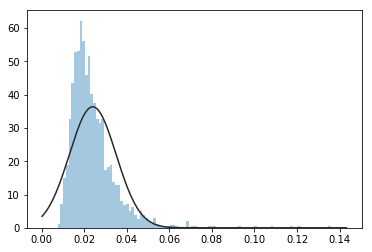

In [64]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(error, kde=False, fit=stats.norm, bins=100)

Check the day with errors above a threshold

In [65]:
ErrorThreshold=0.08
idxMaxError=[i for i in range(0,nPoints) if error[i]>=ErrorThreshold]
calender_error=calendar_info.loc[idxMaxError]
calender_error['error']=error[idxMaxError]

calender_error

,ds,month,weekday,is_weekday,is_holiday_day,error
93,2013-03-31,3,6,0,0.0,0.108351
821,2015-03-29,3,6,0,0.0,0.081908
1465,2017-01-01,1,6,0,1.0,0.093504
1466,2017-01-02,1,0,1,0.0,0.121618
1822,2017-12-24,12,6,0,0.0,0.101188
1825,2017-12-27,12,2,1,0.0,0.135853
1827,2017-12-29,12,4,1,0.0,0.117076


Check the first n days with highest errors 

In [66]:
nDays=30

decreasingOrderIdx=np.argsort(-error)
calendar_Error_Highest=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest['error']=error[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest

,ds,month,weekday,is_weekday,is_holiday_day,error
1825,2017-12-27,12,2,1,0.0,0.135853
1466,2017-01-02,1,0,1,0.0,0.121618
1827,2017-12-29,12,4,1,0.0,0.117076
93,2013-03-31,3,6,0,0.0,0.108351
1822,2017-12-24,12,6,0,0.0,0.101188
1465,2017-01-01,1,6,0,1.0,0.093504
821,2015-03-29,3,6,0,0.0,0.081908
1457,2016-12-24,12,5,0,0.0,0.079627
734,2015-01-01,1,3,1,1.0,0.079110
1464,2016-12-31,12,5,0,0.0,0.072281


Visualize the reconstruction error over a specific day

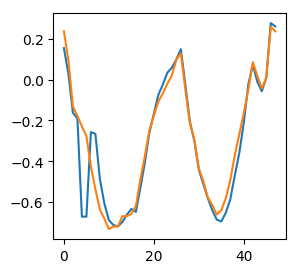

In [67]:
indice=1185 #1185 is the changing hour day end of march
fig = plt.figure(dpi=100,figsize=(3,3))
#set(gca,'Color','k')
plt.plot(x[indice,:])
plt.plot(x_hat[indice,:])

Visualize the reconstruction error over the days with highest error

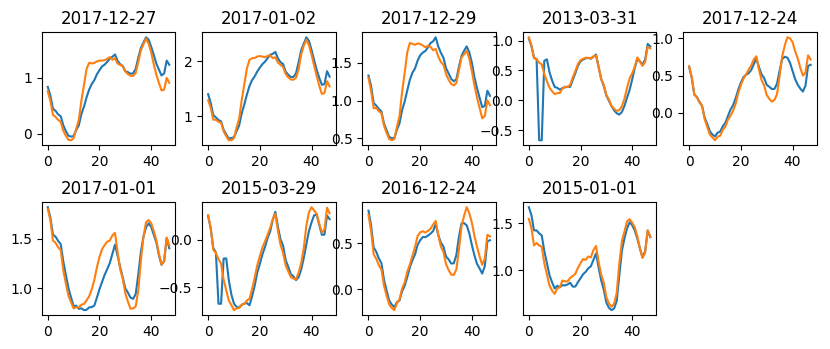

In [68]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,nRows*2))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=decreasingOrderIdx[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_Error_Highest.ds.dt.date.iloc[i-1])

2013-03-31 is the day with a missing hour because of changing day time and the consumption value is set to 0. It is hence normal that it is not well predicted and a good indicator that the model does not tend to overfit.

# Study of holiday predictions

In [69]:
#preparation des features d'interet
yHd=calendar_info['is_holiday_day'].astype(int)
indicesHd=np.array([i for i in range(0, nPoints) if yHd[i] == 1])
yHd_only=yHd[yHd==1]
x_encoded_Hd=x_encoded[indicesHd,]

In [70]:
results_hd=scoreKnnResults(x_encoded,yHd,type='classifier',k=5,cv=10)

## holidays well predicted and not

In [71]:
results_hd_only=[results_hd['predP'][i] for i in indicesHd ]
indices_Hd_predict=[i for i in indicesHd if  results_hd['predP'][i]>=0.5]
indices_Hd_not_predicted=[i for i in indicesHd if  results_hd['predP'][i]<0.5]
calendar_info.loc[indices_Hd_predict]

,ds,month,weekday,is_weekday,is_holiday_day
4,2013-01-01,1,1,1,1.0
124,2013-05-01,5,2,1,1.0
131,2013-05-08,5,2,1,1.0
132,2013-05-09,5,3,1,1.0
143,2013-05-20,5,0,1,1.0
230,2013-08-15,8,3,1,1.0
318,2013-11-11,11,0,1,1.0
362,2013-12-25,12,2,1,1.0
369,2014-01-01,1,2,1,1.0
479,2014-04-21,4,0,1,1.0


In [72]:
len(indices_Hd_predict)

43

In [73]:

calendar_info.loc[indices_Hd_not_predicted]

,ds,month,weekday,is_weekday,is_holiday_day
94,2013-04-01,4,0,1,1.0
198,2013-07-14,7,6,0,1.0
308,2013-11-01,11,4,1,1.0
496,2014-05-08,5,3,1,1.0
673,2014-11-01,11,5,0,1.0
861,2015-05-08,5,4,1,1.0
1038,2015-11-01,11,6,0,1.0
1220,2016-05-01,5,6,0,1.0
1227,2016-05-08,5,6,0,1.0
1458,2016-12-25,12,6,0,1.0


In [74]:
len(indices_Hd_not_predicted)

12

Days not predicted are mostly days on weekends except for  2013-04-01, 2013-11-01, 2014-05-08, 2015-05-08 which are similar to some holidays but also to non-working days. They could hence be predicted as non-working days which is fine

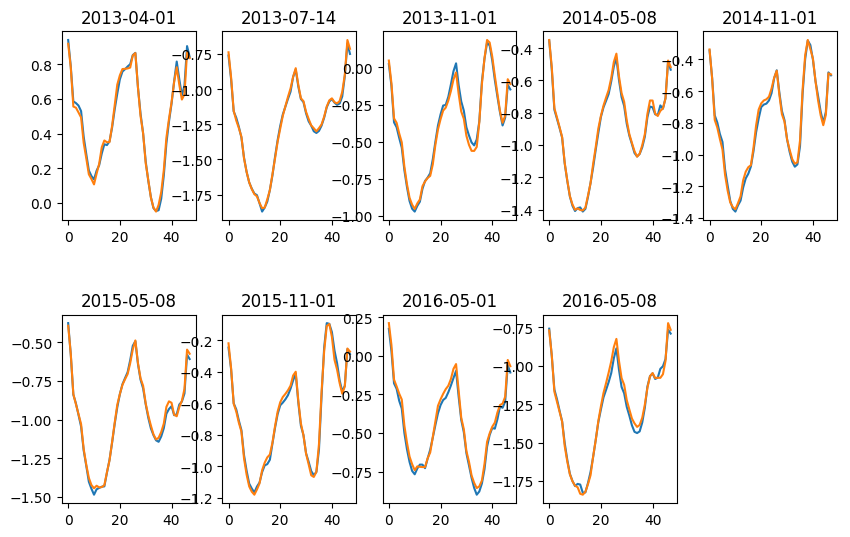

In [76]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,10))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indices_Hd_not_predicted[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])

# Detect Events as local outliers

<function matplotlib.pyplot.show(*args, **kw)>

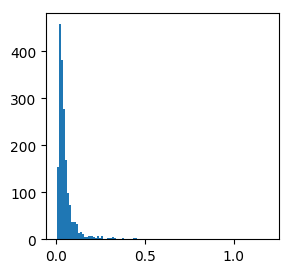

In [77]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(10)
neigh.fit(x_encoded)

[distance_knn,kneighbors]=neigh.kneighbors(x_encoded, 2, return_distance=True)
nearest=distance_knn[:,1]
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest,bins=100)
plt.show

In [78]:
from scipy import stats

stats.describe(nearest)

DescribeResult(nobs=1830, minmax=(0.002066032360427631, 1.1948393669811612), mean=0.05158065464930297, variance=0.004200303640771685, skewness=6.516391073387694, kurtosis=73.90740199324071)

<function matplotlib.pyplot.show(*args, **kw)>

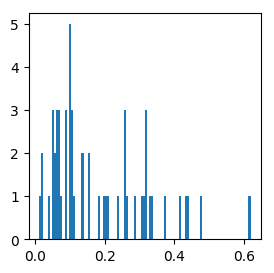

In [79]:
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest[indicesHd],bins=100)
plt.show

In [80]:
stats.describe(nearest[indicesHd])

DescribeResult(nobs=55, minmax=(0.011622080323431544, 0.6193157734187748), mean=0.1811970466420832, variance=0.019042028601234946, skewness=1.0052051409266696, kurtosis=0.401697569895211)

In [81]:
nearestThreshold=0.35
calendar_info.loc[np.where(nearest>=nearestThreshold)]

,ds,month,weekday,is_weekday,is_holiday_day
73,2013-03-11,3,0,1,0.0
94,2013-04-01,4,0,1,1.0
107,2013-04-14,4,6,0,0.0
369,2014-01-01,1,2,1,1.0
405,2014-02-06,2,3,1,0.0
727,2014-12-25,12,3,1,1.0
1458,2016-12-25,12,6,0,1.0
1465,2017-01-01,1,6,0,1.0
1490,2017-01-26,1,3,1,0.0
1491,2017-01-27,1,4,1,0.0


2013-03-11 and 2017-01-26/27 were big snowy events in France. 2013-04-14 was a punctual summer day in early spring. 2014-02-06 was a stormy day. Other days are either holidays or similar non-working days which can be analysed in the projector.

In [82]:
indicesNear=[i for i in range(0,len(nearest)) if nearest[i]>=nearestThreshold]
nearest[np.where(nearest>=nearestThreshold)]

array([0.58221033, 0.43124601, 0.37215222, 0.61931577, 0.44871903,
       0.47452714, 0.41528439, 0.37215222, 0.46516691, 1.19483937,
       0.44303197, 0.45068331, 0.43994025, 0.76402931])

<bound method Figure.show of <Figure size 1000x600 with 14 Axes>>

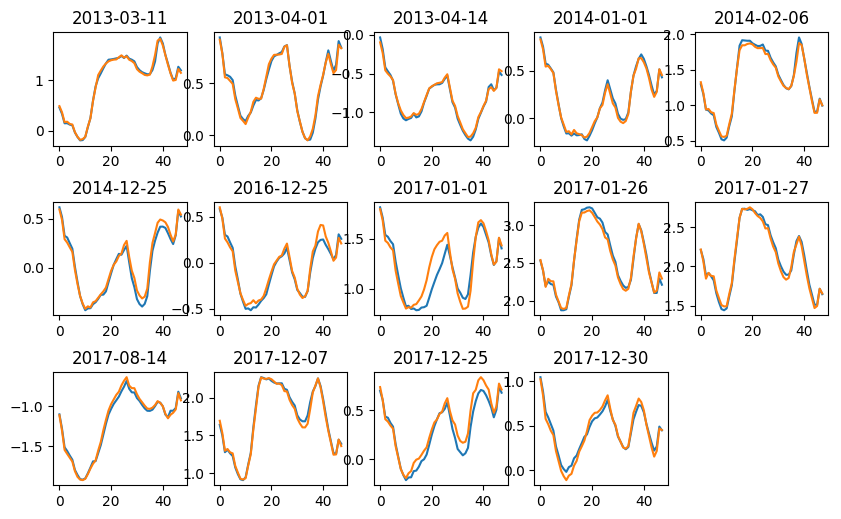

In [83]:
nPlots=len(indicesNear)#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,nRows*2))
for i in range(1, nPlots+1):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indicesNear[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])
fig.show

# Conclusions
- We managed to properly condition on the expert feature passed as the residual latent space is almost independant from them
- We recover holidays which are well-represented and can be predicted
- We can use the latent projection to discover other non-working days to label such as days near holidays or Christmas week
- When looking at local outliers, we discover first weather events to further analyze in a more appropriate conditional representation were they are better represented.


